# ReACT with massive neutrinos and Dark Scattering

For the following example you need the DS version of CLASS installed. The easiest way to do this is to get it from github at:

`https://github.com/PedroCarrilho/class_public/tree/IDE_DS`

We will look at an example of CPL dark energy with DS with massive neutrinos. 

If you want to have modified gravity such as f(R) or DGP with massive neutrinos you will need a wrapper for the associated boltzmann code, or work in developer mode and use the example files in reactions/examples. 

In [1]:
from classy import Class

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

from scipy.interpolate import CubicSpline

Set the cosmology and let CAMB compute the linear power spectrum.

In [2]:
Omega_c = 0.2598
Omega_b = 0.0482
h = 0.678
n_s = 0.966 
A_s = 2.115e-9

# Model selection and parameter (1:GR, 2:f(R), 3:DGP, 4:quintessence with interaction, 5:CPL with interaction)
mymodel = "CPL with interaction"
w0 = -1.1
w_a = 0.3
xi_ds = 50.
# set mass of massive neutrino species 
m_nu = 0.1
Omega_nu = m_nu/93.14/h**2
# Loop in spherical collapse 
massloop = 50

Omega_m = Omega_c + Omega_b + Omega_nu

# redshift array: must use at least 5 values of hmcode will not work
z_lin = np.linspace(0.0, 1.0, 5)

# wavemode array in units of h/Mpc
k_lin = np.geomspace(1e-4, 50, 500)

In [3]:
# Use class for LCDM
cosmo_lcdm= Class()
cosmo_lcdm.set({'output':'tCl mPk dTk vTk','P_k_max_1/Mpc':50,'z_max_pk':1,
               'h':h,'N_ur':2.0308,'N_ncdm':1,'m_ncdm':m_nu,
               'gauge':'Newtonian',
               'omega_b':Omega_b*h**2,'omega_cdm':Omega_c*h**2,
               'A_s':A_s,'n_s':n_s})

cosmo_lcdm.compute()

sigma8_lcdm=cosmo_lcdm.sigma8()

Pk_lcdm = np.array([[cosmo_lcdm.pk(k, z)*h*h*h for k in h*k_lin] for z in z_lin])
Pk_lcdm_cb = np.array([[cosmo_lcdm.pk_cb(k, z)*h*h*h for k in h*k_lin]for z in z_lin])

In [4]:
# Use class for CPL case without DS
cosmo_cpl = Class()
cosmo_cpl.set({'output':'tCl mPk dTk vTk','P_k_max_1/Mpc':50,'z_max_pk':1,
               'h':h,'N_ur':2.0308,'N_ncdm':1,'m_ncdm':m_nu,
               'cs2_fld':1.,
               'w0_fld':w0,'wa_fld':w_a,'xi_ds':0.0,'Omega_Lambda':0.,'gauge':'Newtonian',
               'use_ppf':'yes','dark_scattering':'yes',
               'omega_b':Omega_b*h**2,'omega_cdm':Omega_c*h**2,
               'A_s':A_s,'n_s':n_s})

cosmo_cpl.compute()

sigma8_cpl=cosmo_cpl.sigma8()

Pk_cpl = np.array([[cosmo_cpl.pk(k, z)*h*h*h for k in h*k_lin] for z in z_lin])
Pk_cpl_cb = np.array([[cosmo_cpl.pk_cb(k, z)*h*h*h for k in h*k_lin]for z in z_lin])

In [5]:
# Use class for CPL case with DS
cosmo_cpl_xi = Class()
cosmo_cpl_xi.set({'output':'tCl mPk dTk vTk','P_k_max_1/Mpc':50,'z_max_pk':1,
               'h':h,'N_ur':2.0308,'N_ncdm':1,'m_ncdm':m_nu,
               'cs2_fld':1.,
               'w0_fld':w0,'wa_fld':w_a,'xi_ds':xi_ds,'Omega_Lambda':0.,'gauge':'Newtonian',
               'use_ppf':'yes','dark_scattering':'yes',
               'omega_b':Omega_b*h**2,'omega_cdm':Omega_c*h**2,
               'A_s':A_s,'n_s':n_s})

cosmo_cpl_xi.compute()

sigma8_cpl_xi=cosmo_cpl_xi.sigma8()

Pk_cpl_xi = np.array([[cosmo_cpl_xi.pk(k, z)*h*h*h for k in h*k_lin] for z in z_lin])
Pk_cpl_cb_xi = np.array([[cosmo_cpl_xi.pk_cb(k, z)*h*h*h for k in h*k_lin]for z in z_lin])

Now use ReACT to get the reaction

In [6]:
# Correct xi_ds that goes into react, to account for non-cdm species (Eq. 23 of https://arxiv.org/abs/2111.13598)
Rc=Omega_c/Omega_m
unit_conv = 0.0194407
Corr_xi = xi_ds*Rc/(1.+ unit_conv*h*(1.-Omega_m)*(1. + w0)*xi_ds*(1.-Rc))

In [7]:
react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
z_react = z_lin[z_lin < 2.5]

# Compute reaction with DS
R, pofk_lin_react, sigma_8_mod = react.compute_reaction_nu(
                                h, n_s, Omega_m, Omega_b, Omega_nu, A_s, 
                                z_react, k_lin, Pk_cpl_xi.flatten(), Pk_cpl_cb_xi.flatten(),
                                k_lin, Pk_lcdm_cb.flatten(), 
                                pscale = 0.05,
                                model=mymodel, 
                                fR0=0., Omega_rc=0, w=w0, wa=w_a, xi=Corr_xi,
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  
# Compute reaction without DS
R0, pofk_lin_react0, sigma_8_mod0 = react.compute_reaction_nu(
                                h, n_s, Omega_m, Omega_b, Omega_nu, A_s, 
                                z_react, k_lin, Pk_cpl.flatten(), Pk_cpl_cb.flatten(),
                                k_lin, Pk_lcdm_cb.flatten(), 
                                pscale = 0.05,
                                model=mymodel, 
                                fR0=0., Omega_rc=0, w=w0, wa=w_a, xi=0.0, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  


Reaction error: You must supply the input transfer functions if using a modified linear input
Reaction error: You must supply the input transfer functions if using a modified linear input


Now plot the reaction and matter spectrum as a consistency check 

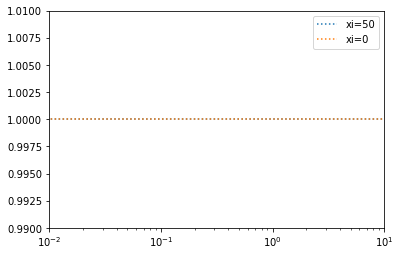

In [8]:
plt.semilogx(k_lin, pofk_lin_react[0]/Pk_cpl_xi[0],linestyle='dotted',label='xi=50')
plt.semilogx(k_lin, pofk_lin_react0[0]/Pk_cpl[0],linestyle='dotted',label='xi=0')

plt.xlim([1e-2,10])
plt.ylim([0.99,1.01])

plt.legend()

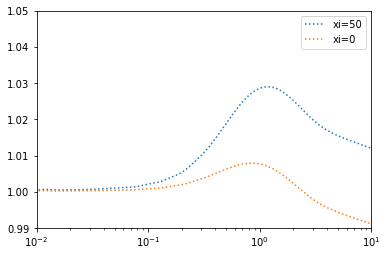

In [9]:
plt.semilogx(k_lin, R[0],linestyle='dotted',label='xi=50')
plt.semilogx(k_lin, R0[0],linestyle='dotted',label='xi=0')

plt.xlim([1e-2,10])
plt.ylim([0.99,1.05])

plt.legend()

Finally, use HMCODE to compute the pseudo power spectrum

In [10]:
import pyhmcode as hmcode

In [11]:
# Setup HMcode internal cosmology
c_lcdm = hmcode.Cosmology()

# Set HMcode internal cosmological parameters
c_lcdm.om_m = cosmo_lcdm.Omega_m()
c_lcdm.om_b = Omega_b
c_lcdm.om_v = 1.-cosmo_lcdm.Omega_m()
c_lcdm.h = h
c_lcdm.ns = n_s
c_lcdm.sig8 = sigma8_lcdm
c_lcdm.m_nu = m_nu

# Set the linear power spectrum for HMcode
c_lcdm.set_linear_power_spectrum(k_lin, np.asarray(z_lin), Pk_lcdm)

# Set the halo model in HMcode
# Options: HMcode2015, HMcode2016, HMcode2020
hmod = hmcode.Halomodel(hmcode.HMcode2020, verbose=False)

# Power spectrum calculation
Pk_hm_lcdm = hmcode.calculate_nonlinear_power_spectrum(c_lcdm, hmod, verbose=False)



In [12]:
# Setup HMcode internal cosmology
c_w09= hmcode.Cosmology()

# Set HMcode internal cosmological parameters
c_w09.om_m = cosmo_cpl.Omega_m()
c_w09.om_b = Omega_b
c_w09.om_v = 1.-cosmo_cpl.Omega_m()
c_w09.h = h
c_w09.ns = n_s
c_w09.sig8 = sigma8_cpl
c_w09.m_nu = m_nu

# Set the linear power spectrum for HMcode
c_w09.set_linear_power_spectrum(k_lin, np.asarray(z_lin), Pk_cpl)

# Set the halo model in HMcode
# Options: HMcode2015, HMcode2016, HMcode2020
hmod = hmcode.Halomodel(hmcode.HMcode2020, verbose=False)
# Power spectrum calculation
Pk_hm_w09 = hmcode.calculate_nonlinear_power_spectrum(c_w09, hmod, verbose=False)

In [13]:
# Setup HMcode internal cosmology
c_w09_xi= hmcode.Cosmology()

# Set HMcode internal cosmological parameters
c_w09_xi.om_m = cosmo_cpl_xi.Omega_m()
c_w09_xi.om_b = Omega_b
c_w09_xi.om_v = 1.-cosmo_cpl_xi.Omega_m()
c_w09_xi.h = h
c_w09_xi.ns = n_s
c_w09_xi.sig8 = sigma8_cpl_xi
c_w09_xi.m_nu = m_nu

# Set the halo model in HMcode
# Options: HMcode2015, HMcode2016, HMcode2020
hmod = hmcode.Halomodel(hmcode.HMcode2020, verbose=False)

# Set the linear power spectrum for HMcode
c_w09_xi.set_linear_power_spectrum(k_lin, np.asarray(z_lin), Pk_cpl_xi)

# Power spectrum calculation
Pk_hm_w09_xi = hmcode.calculate_nonlinear_power_spectrum(c_w09_xi, hmod, verbose=False)


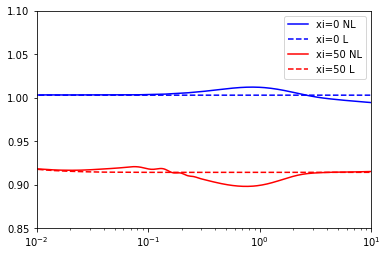

In [14]:
# Plot ratios to LCDM
plt.semilogx(k_lin,(Pk_hm_w09[0]*R0[0]/Pk_hm_lcdm[0]),'b-',label='xi=0 NL')
plt.semilogx(k_lin,(Pk_cpl[0]/Pk_lcdm[0]),'b--',label='xi=0 L')
plt.semilogx(k_lin,(Pk_hm_w09_xi[0]*R[0]/Pk_hm_lcdm[0]),'r-',label='xi=50 NL')
plt.semilogx(k_lin,(Pk_cpl_xi[0]/Pk_lcdm[0]),'r--',label='xi=50 L')

plt.ylim([0.85,1.1])
plt.xlim([1e-2,10])
plt.legend()